# Prediction As Classification
Continuing the 2800-HK price prediction from classification perspective

## Step 1: Import Modules and load raw data

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

np.random.seed(1000)

In [2]:
#Import sklearn
from sklearn.preprocessing import scale

In [3]:
#Import Keras module
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

Using TensorFlow backend.


In [4]:
#Check GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15520730019394190121
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11308947866
locality {
  bus_id: 1
}
incarnation: 17480548225656454194
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"
]


In [5]:
#pretty plots
%matplotlib inline

In [6]:
#Import price data
#Load the historical prices of 2800-HK, with lags 1 to lag 20
price_hist_data = pd.read_csv('price_only.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
price_hist_data.head()

,P,P_L1,P_L2,P_L3,P_L4,P_L5,P_L6,P_L7,P_L8,P_L9,...,P_L11,P_L12,P_L13,P_L14,P_L15,P_L16,P_L17,P_L18,P_L19,P_L20
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,22.05,21.85,...,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15,22.25,22.85
2007-09-03,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,22.05,...,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15,22.25
2007-09-04,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,...,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15
2007-09-05,24.35,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,...,22.05,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85
2007-09-06,24.50,24.35,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,...,22.70,22.05,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70


In [7]:
#Save dates for later use
dates = price_hist_data.index

In [8]:
#Import Fundamentals Data
fund_data = pd.read_csv('new_index_data.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
fund_data.head() 

,Close,High,Low,Ask,Bid,Open,20D Vol,MA5,MA15,MA12,...,DY_LTM,DY_NTM,ADV_VOL,PAYOUT,ANALYST_SENTIMENT,EPS_GRW_FY1,EPS_GRW_FY2,PE_NTM,PE_LTM,C2D_LTM
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,24.35,24.35,24.35,24.35,24.35,23.95,2.367823,23.82,22.841667,22.696667,...,2.782797,2.880128,99.419898,48.051962,1.909071,30.724490,2.717280,16.695058,16.975805,58.050474
2007-09-03,24.30,24.30,24.30,24.30,24.30,24.30,2.266743,23.90,23.120832,22.830000,...,2.784563,2.892308,11.570023,48.305678,1.835359,31.005439,1.876752,16.709085,16.925571,58.154835
2007-09-04,24.30,24.30,24.30,24.30,24.30,24.30,2.259649,24.02,23.412500,22.960000,...,2.784339,2.894377,69.555725,48.307102,1.725886,31.040968,1.891823,16.697662,16.919413,58.177640
2007-09-05,24.35,24.35,24.35,24.35,24.35,24.55,2.172140,24.22,23.620832,23.136667,...,2.767348,2.867314,24.265623,48.267351,1.741908,30.716929,1.878484,16.841225,17.017692,58.195446
2007-09-06,24.50,24.50,24.50,24.50,24.50,24.30,2.160638,24.36,23.825000,23.373333,...,2.775339,2.878880,88.845002,48.288397,1.696151,31.336520,1.861943,16.780660,16.975485,58.224743


In [9]:
#Import Global index data
idx_data = pd.read_csv('indices.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
idx_data.head()

,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,India S&P BSE SENSEX,TOPIX,KOSPI Composite Index,Taiwan TAIEX,FTSE Bursa Malaysia KLCI,FTSE Straits Times Index,Philippines PSE PSEi,...,Turkey BIST 100,S&P 500,DJ Industrial Average,Colombia IGBC,Canada S&P/TSX Composite,Brazil Bovespa Index,Mexico IPC,Israel TA-125,Saudi Arabia All Share (TASI),FTSE JSE All Share
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,23984.14,5218.825,6248.3,15318.60,1608.25,1873.24,8982.16,1273.93,3328.43,3365.29,...,50198.60,1473.99,13357.74,10728.74,13660.48,54637.24,30347.86,1034.67,8226.97,28660.35
2007-09-03,23904.09,5321.055,6272.5,15422.05,1605.44,1881.81,8979.96,1284.14,3321.36,3369.14,...,49936.94,1473.99,13357.74,10750.79,13660.48,54832.51,30797.60,1047.33,8017.54,28887.48
2007-09-04,23886.07,5294.045,6297.1,15465.40,1596.74,1874.74,8922.98,1283.75,3308.81,3312.30,...,50032.59,1489.42,13448.86,10880.85,13755.23,55250.47,30932.71,1054.69,7878.70,29051.96
2007-09-05,24069.17,5310.716,6274.3,15446.15,1569.47,1865.59,8913.85,1297.93,3375.02,3342.35,...,49421.38,1472.29,13305.47,10819.91,13683.28,54407.83,30809.55,1048.70,7853.66,28696.67
2007-09-06,24050.40,5393.660,6265.3,15616.31,1568.52,1888.81,9017.08,1298.85,3399.49,3326.53,...,49601.39,1478.55,13363.35,10844.40,13795.69,54569.00,30816.95,1033.23,7853.66,28850.19


## Step 2: Pre-process Raw Data
1. Generate labels
2. Apply lags to global index data
3. Normalize features

In [10]:
#Generate Labels from Price History Data
#Generate UP/DOWN labels from log change
cutoff_perc = 0.0005 #0.05% return as cuttoff to define UP label
lag = 1 #forward returns

labels = np.zeros([price_hist_data.shape[0]])

#Caluclate log-returns
ret = np.log(price_hist_data['P'].shift(-lag)/price_hist_data['P'])
labels = [2 if r > cutoff_perc else 0 if r < -cutoff_perc else 1 for r in ret]

In [11]:
ret[-10:]

Date
2017-10-16    0.001688
2017-10-17    0.000000
2017-10-18   -0.017007
2017-10-19    0.010239
2017-10-20   -0.006814
2017-10-23   -0.003425
2017-10-24    0.003425
2017-10-25   -0.003425
2017-10-26    0.006838
2017-10-27         NaN
Name: P, dtype: float64

In [14]:
#Applying lags to index data
#Seperate the indices into 2 classes - lag or no_lag
no_lag = [0, 1, 2, 4, 5, 6, 9, 10]
lag = [i for i in range(0,idx_data.shape[1]) if i not in no_lag]

#Processing the dataset by applying appropriate lags
lagged_data = idx_data.iloc[:,lag].shift(1)
idx_data = pd.concat([idx_data.iloc[:,no_lag], lagged_data], axis=1)


In [15]:
#Remove first row and last row
idx_data = idx_data.iloc[1:-1, :]
price_hist_data = price_hist_data.iloc[1:-1, :]
fund_data = fund_data.iloc[1:-1, :]
labels=labels[1:-1]

In [16]:
#Check Dimensions to make sure everythings right before continuing..
print("Shape of idx_data: ", idx_data.shape)
print("Shape of price_hist_data: ", price_hist_data.shape)
print("Shape of fund_data: ", fund_data.shape)
print("Shape of labels: ", len(labels))

Shape of idx_data:  (2502, 42)
Shape of price_hist_data:  (2502, 21)
Shape of fund_data:  (2502, 31)
Shape of labels:  2502


In [17]:
#Training data
X = np.array(pd.concat([price_hist_data, idx_data, fund_data], axis=1))
y = to_categorical(labels, num_classes=3)

In [18]:
#Checking whether there are NAs
[np.sum(np.isnan(X), axis=0) > 0] == True

False

## Step 3: Split training, validation and test set

In this stage we have a look-ahead bias free set of data (X) and the labels y. Next, we will need to:
- Normalize the input data. To avoid look ahead bias, we will z-score the features, using ONLY the training set.
- Next, generate input data into LSTM network. We will need an overlapping sequence at 1-day window as input samples. Specifically suppose the *timestep* is 240, we will have a list of array consists of *number of rows of X* - 240 entries, each element has dimentions (240, num_of_features)


In [19]:
#Function to split raw data into training, validation and test set, returns a numpy array.
def split_data(input_data=[], train_size=0.8, val_size=0.2, test_size=0):
    
    #------------------------------------------------
    #PARAM: input_data: numpy nd array
    #PARAM: training_size: size of training set in decimal
    #PARAM: val_size: size of validation set in decimal
    #PARAM: test_size: size of test set in decimal
    #OUTPUT: tuple (train_set, validation_set, test_set)
    #------------------------------------------------
    
    #First check whether traing_size + val_size + test_size = 1 and each of the entries are positive
    assert(train_size + val_size + test_size==1), "Sum of training, validation and test size needs to be 1!"
    assert(train_size * val_size * test_size > 0), "Sizes have to be positive!"
    
    #Check input_data type is numpy array, after casting
    if type(input_data) != 'numpy.ndarray':
        input_data = np.array(input_data) 
    
    assert(isinstance(input_data, np.ndarray)), "Input has to be a numpy array!"
    
    
    #Calculate cut-off points
    train_cut_index = int(train_size * input_data.shape[0])
    val_cut_index = train_cut_index + int(val_size * input_data.shape[0])
    
    #Split the data
    if len(input_data.shape) == 1:
        train, val, test = input_data[:train_cut_index], input_data[train_cut_index:val_cut_index], input_data[val_cut_index:]
    else:
        train, val, test = input_data[:train_cut_index,:], input_data[train_cut_index:val_cut_index, :], input_data[val_cut_index:, :]
    
    return train, val, test

In [20]:
#------------
#TEST OUTPUT
#------------
#Split data
X_train, X_val, X_test = split_data(X, train_size=0.7, val_size=0.15, test_size=0.15)
y_train, y_val, y_test = split_data(y, train_size=0.7, val_size=0.15, test_size=0.15)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1751, 94)
(375, 94)
(376, 94)
(1751, 3)
(375, 3)
(376, 3)


In [21]:
#Function to re-structure the data to get batches. Re-shape the data to have overlapping training set for time-series learning.
def get_inputs(input_data, labels, batch_size, timesteps):
    
    #First get the total number of samples generated
    n_seq = input_data.shape[0] - timesteps + 1
    
    #features, classes
    n_dim = input_data.shape[1]
    n_class = labels.shape[1]
    
    #Calculate the number of batches possible
    n_samples = n_seq * timesteps
    n_batches = n_samples // (batch_size * timesteps)
    
    #Assert n_batches > 0
    assert(n_batches > 0), 'Not enough data to form 1 batch!'
    
    #Generate labels to have (batch_size, 1)
    targets=labels[:n_batches * batch_size,:]
    
    
    #Generate training data with dim (batch_size, timesteps, n_features)
    output = []
    
        
    for jj in range(0, n_batches):
    #Generate the sequences
        
        #if jj == n_batches:
            
            #output.append([input_data[jj*batch_size:, :]])
            #targets.append([labels[jj*batch_size:, :]])            
            #yield np.vstack(output), np.vstack(targets  )
            
        #else:            
        for ii in range(jj * batch_size, (jj + 1) * batch_size):                    
            #Getting the overlapping samples
            output.append([scale(input_data[ii:ii+timesteps, :])])
            #targets.append([labels[ii:ii+timesteps, :]])

    return np.vstack(output), targets


In [22]:
#------------
#TEST OUTPUT
#------------
#get inputs
t = np.reshape(np.arange(1,51), (10,5))
s = np.reshape(np.arange(1,21), (10,2))

#for (x, y) in get_inputs(t,s, 3, 4):
#    print('training size: ', x.shape)
#    print('training: \n', x)
#    print('label size: ', y.shape)
#    print('labels: \n', y)

test_train, test_label = get_inputs(t,s,3,4)
    

#print(test_train[0:1])
#print(test_label[0:1])
#print(t)
print(test_train.shape)
print(test_label.shape)
#print(test_train)
#test_train.reshape((-1, 4, 5))

(6, 4, 5)
(6, 2)


/home/bryan_yychik/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


## Step 4: Train Model

In [23]:
#Define Parameters
learning_rate = 1e-5
epochs= 500
loss = 'categorical_crossentropy'
batch_size = 256
timesteps = 14
n_dim = X.shape[1]
n_classes = 3


In [24]:
#Optimizer - using Adam Optimizer
optimizer = optimizers.Adam(lr=learning_rate)

In [25]:
#Generate Inputs
X_train_1, y_train_1 = get_inputs(X_train, y_train, batch_size, timesteps)
X_val_1, y_val_1 = get_inputs(X_val, y_val, batch_size, timesteps)
X_test_1, y_test_1 = get_inputs(X_test, y_test, batch_size, timesteps)

In [26]:
#Define LSTM Network object
def build_network(n_hidden_layer, n_classes, dropout, input_shape, batch_size, return_sequences=True, stateful=True):
    
    #Define network architect
    model = Sequential()
    model.add(LSTM(n_hidden_layer[0], 
                   input_shape=input_shape,
                   kernel_initializer='truncated_normal',
                   recurrent_initializer='truncated_normal',
                   bias_initializer='RandomUniform',
                   batch_size=batch_size, 
                   return_sequences=return_sequences, 
                   stateful=stateful))
    
    model.add(Dropout(dropout[0]))
    
    model.add(LSTM(n_hidden_layer[1], 
                   return_sequences=False,
                   kernel_initializer='truncated_normal',
                   recurrent_initializer='truncated_normal',
                   bias_initializer='RandomUniform',
                   stateful=stateful))
    
    model.add(Dropout(dropout[1]))
    
    model.add(Dense(n_hidden_layer[2], activation='relu', kernel_initializer='truncated_normal'))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [27]:
#lstm1 = build_network(best_n_hidden, n_classes, [0,0], input_shape=(timesteps, n_dim), batch_size=batch_size)

In [28]:
#Compile
#lstm1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [29]:
#fitted = lstm1.fit(X_train_1, y_train_1, batch_size=batch_size, epochs=1000, verbose=1, validation_data=(X_val_1, y_val_1), shuffle=True)

In [30]:
#plot_metric(fitted, 'loss')
#plot_metric(fitted, 'acc')

## Step 5: Evaluate


In [31]:
### Plot Training vs Validation Curve
def plot_metric(fitted, metric):
    plt.figure()
    plt.plot(fitted.history[metric])
    plt.plot(fitted.history['val_' + metric])
    plt.title('Training ' + metric + ' & Validation ' + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Training ' + metric, 'Validation ' + metric])
    plt.show()

## Step 6: Parameter Tuning


Grid Search the following parameters:
- Learning Rate & decay rate
- Number of Hidden Layers
- Dropout Rate
- Timesteps

In [32]:
%store

Stored variables and their in-db values:
best_drop_out             -> (0.16431643902664886, 0.10116406923482804)
best_lr                   -> 6.2257133109410074e-05
best_n_hidden             -> (104, 50, 40)
best_timestep             -> 11
do                        -> [(0.30654380648074059, 0.15518723342569127), (0.20
do_loss                   -> [0.96192556619644165, 0.89160728454589844, 0.98137
hd                        -> [(167, 129, 46), (69, 86, 107), (53, 182, 132), (1
hd_loss                   -> [0.86914741992950439, 0.84087979793548584, 8.56273
learnrate                 -> [6.7700028967629204e-05, 6.8839231364996276e-05, 1
lr_loss                   -> [0.81691169738769531, 0.79937803745269775, 0.82949
t_loss                    -> [0.95131367444992065, 0.93839895725250244, 0.90483
tt                        -> array([ 37,  65,  96,  46, 101, 103,  82, 107,  77


In [33]:
%store -r

## Number of Hidden Layers

In [ ]:
#Define number of random trials
n_trials = 100

In [ ]:
#Initiate empty list to store best validation loss for a particular number of hidden layers
hd = []
hd_loss = []
steps = 1

#Loop through the learning rate and train network
for h in zip(np.random.randint(50,250, n_trials), np.random.randint(50,250, n_trials), np.random.randint(10,200, n_trials)): 
    
    hd_network = build_network(h, n_classes, [0,0], input_shape=(timesteps, n_dim), batch_size=batch_size)
    
    #Optimizer
    optimizer = optimizers.Adam(lr=0.1, decay=1e-5)
    
    #Compile
    hd_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted_hidden = hd_network.fit(X_train_1, y_train_1, batch_size=batch_size, epochs=20, verbose=0, validation_data=(X_val_1, y_val_1), shuffle=True)
    
    #Min loss
    val_loss = np.min(fitted_hidden.history['val_loss'])
    
    #Display
    print('Steps: %d,' % steps, 'Number of layers: (%d, %d, %d), ' % (h[0], h[1], h[2]), 'Best Validation Loss: %.4f' %  val_loss)
    
    #Save
    hd.append(h)
    hd_loss.append(val_loss)
    
    #Update
    steps += 1

In [ ]:
#Best number of hidden layer
best_hidden_loss = np.min(hd_loss)
best_n_hidden = hd[np.argmin(hd_loss)]
print('Best Number of Hidden Layer: ', best_n_hidden, " Validation Loss: %.4f " % best_hidden_loss)
%store best_n_hidden
%store hd_loss
%store hd

In [ ]:
# create the figure, add a 3d axis, set the viewing angle
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

x = np.array(hd)[:,0]
y = np.array(hd)[:,1]
z = np.array(hd)[:,2]

p = ax.scatter(x, y, z, c=hd_loss, s=200)
ax.set_xlabel('1st LSTM Layer')
ax.set_ylabel('2nd LSTM Layer')
ax.set_zlabel('Dense Layer')
plt.colorbar(p)


## Learning Rate

In [ ]:
#Define early Stop call back
earlyStopping = EarlyStopping(patience=10, min_delta=1e-6)

In [ ]:
#Initiate empty list to store best validation loss for a particular learning rate
learnrate = []
lr_loss = []
steps = 1

for l in np.random.uniform(1e-4, 1e-6, n_trials):

    lr_network = build_network(best_n_hidden, n_classes, [0,0], input_shape=(timesteps, n_dim), batch_size=batch_size)

    #Optimizer
    optimizer = optimizers.Adam(lr=l)

    #Compile
    lr_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    #Train
    fitted_lr = lr_network.fit(X_train_1, y_train_1, 
                               batch_size=batch_size, 
                               epochs=300, verbose=0, 
                               validation_data=(X_val_1, y_val_1), 
                               shuffle=True, 
                               callbacks=[earlyStopping])
    
    #Min loss
    val_loss = np.min(fitted_lr.history['val_loss'])
    
    #Display
    print('Steps: %d,' % steps, 'Learning Rate: %.6f, ' % l, 'Best Validation Loss: %.4f' %  val_loss)
    
    #Save
    learnrate.append(l)
    lr_loss.append(val_loss)
    
    #Update
    steps += 1
    

In [ ]:
#Best leanring rate
best_lr_loss = np.min(lr_loss)
best_lr = learnrate[np.argmin(lr_loss)]
print('Best Learning Rate: %f' % best_lr, " Validation Loss: %.4f " % best_lr_loss)
%store best_lr
%store lr_loss
%store learnrate

In [ ]:
sorted_loss = [l for _, l in sorted(zip(learnrate, lr_loss))]
sorted_lr = sorted(learnrate)

plt.plot(sorted_lr, sorted_loss)

## Dropout rate

In [ ]:
#Initiate empty list to store best validation loss for a particular learning rate
do = []
do_loss = []
steps = 1

#Loop through the learning rate and train network
for d in zip(np.random.uniform(0.1, 0.7, n_trials), np.random.uniform(0.1, 0.7, n_trials)):

    do_network = build_network(best_n_hidden, n_classes, d, input_shape=(timesteps, n_dim), batch_size=batch_size)
    
    #Optimizer
    optimizer = optimizers.Adam(lr=best_lr)
    
    #Compile
    do_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted_dropout = do_network.fit(X_train_1, y_train_1, batch_size=batch_size, epochs=20, verbose=0, validation_data=(X_val_1, y_val_1), shuffle=True)
    
    #Min loss
    val_loss = np.min(fitted_dropout.history['val_loss'])
    
    #Display
    print('Steps: %d,' % steps, 'Dropout: (%.4f, %.4f), ' % (d[0], d[1]), 'Best Validation Loss: %.4f' %  val_loss)
    
    #Save
    do.append(d)
    do_loss.append(val_loss)
    
    #Update
    steps += 1

In [ ]:
best_do_loss = np.min(do_loss)
best_drop_out = do[np.argmin(do_loss)]
print('Best Drop out probability: (%.2f, %.2f) ' % (best_drop_out[0], best_drop_out[1]), 'Validation Loss: %.4f' % best_do_loss)
%store best_drop_out
%store do_loss
%store do

In [ ]:
# create the figure, add a 3d axis, set the viewing angle
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

x = np.array(do)[:,0]
y = np.array(do)[:,1]

p = ax.scatter(x, y, c=do_loss, s=200)
ax.set_xlabel('1st Dropout')
ax.set_ylabel('2nd Dropout')
ax.set_title('Dropout')
plt.colorbar(p)

## Timesteps

In [ ]:
tt = np.random.randint(10, 120, n_trials)

In [ ]:
#Initiate empty list to store best validation loss for a particular timestep
t_loss = []
steps = 1
ts = []

#Loop through the learning rate and train network
for t in tt:
    
    #Generate inputs on timesteps
    X_train_2, y_train_2 = get_inputs(X_train, y_train, batch_size, t)
    X_val_2, y_val_2 = get_inputs(X_val, y_val, batch_size, t)
    
    #Build network
    t_network = build_network(best_n_hidden, n_classes, best_drop_out, input_shape=(t, n_dim), batch_size=batch_size)
    
    #Optimizer
    optimizer = optimizers.Adam(lr=best_lr)
    
    #Compile
    t_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted_timesteps = t_network.fit(X_train_2, y_train_2, batch_size=batch_size, epochs=20, verbose=0, validation_data=(X_val_2, y_val_2), shuffle=True)
    
    #Min Validation loss
    val_loss = np.min(fitted_timesteps.history['val_loss'])
    
    #Display
    print('Steps: %d,' % steps, 'Timesteps: %d' % t, 'Best Validation Loss: %.4f' % val_loss)
    
    #Save
    t_loss.append(val_loss)
    
    #Update
    steps += 1

In [ ]:
best_t_loss = np.min(t_loss)
best_timestep = tt[np.argmin(t_loss)]
print('Best Timestep: %d , ' % best_timestep, 'Validation Loss: %.4f' % best_t_loss)

%store best_timestep
%store t_loss
%store tt

In [ ]:
sorted_tloss = [l for _, l in sorted(zip(tt, t_loss))]
sorted_t = sorted(tt)

plt.plot(sorted_t, sorted_tloss)

In [ ]:
print('Summary')
print('-------------')
print('Learning Rate: %.8f' % best_lr)
print('Number of layers: ', best_n_hidden)
print('Dropout Probability: (%.2f, %.2f)' % best_drop_out)
print('Timesteps: ', best_timestep)

## Step 7: Refit using best parameters


In [34]:
#In case the best parameters are not loaded..
#best_drop_out = (0.16, 0.1)
#best_lr = 0.00006226
#best_n_hidden = (104, 50, 40)
#best_timestep = 11

In [35]:
X_train_best, y_train_best = get_inputs(X_train, y_train, batch_size, best_timestep)
X_val_best, y_val_best = get_inputs(X_val, y_val, batch_size, best_timestep)
X_test_best, y_test_best = get_inputs(X_test, y_test, 1, best_timestep) #Batch-size is 1 for online prediction

In [36]:
from keras import backend as K

#Precision
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#Recall
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


#F1
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

#Matthews Correlation
def mcor(y_true, y_pred):
    #matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) 
 
    return numerator / (denominator + K.epsilon())

    

In [37]:
#Define early Stop call back
earlyStopping = EarlyStopping(patience=20, min_delta=1e-8)

In [ ]:
#Decay Rate
#decay_rate=0.00009

#Refit using tuned parameters
best_network = build_network(best_n_hidden, n_classes, best_drop_out, input_shape=(best_timestep, n_dim), batch_size=batch_size)

optimizer = optimizers.Adam(lr=best_lr)

best_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mcor, f1_score, precision, recall])

best_fit = best_network.fit(X_train_best, y_train_best, 
                            batch_size=batch_size, 
                            epochs=300, 
                            verbose=1,
                            validation_data=(X_val_best, y_val_best),
                            callbacks=[earlyStopping],
                            shuffle=True)

In [ ]:
#Save model
best_network.save('best_fit.h5')

## Step 8: Model Evaluation

## Model Check Point

In [38]:
#Function to load saved model
from keras.models import load_model
best_network = load_model('best_fit.h5', custom_objects={'mcor': mcor, 'precision': precision, 'recall': recall, 'f1_score': f1_score})

In [39]:
X_train_best, y_train_best = get_inputs(X_train, y_train, batch_size, best_timestep)
X_val_best, y_val_best = get_inputs(X_val, y_val, batch_size, best_timestep)
X_test_best, y_test_best = get_inputs(X_test, y_test, 1, best_timestep)

In [40]:
y_test_best.shape

(366, 3)

### Plot Loss Curves and other metrics

In [41]:
#Plot metrics
plot_metric(best_fit, 'loss')
plot_metric(best_fit, 'acc')
plot_metric(best_fit, 'mcor')
plot_metric(best_fit, 'f1_score')
plot_metric(best_fit, 'precision')
plot_metric(best_fit, 'recall')

NameError: name 'best_fit' is not defined

### Confusion Matrix

In [42]:
#Turn the batch-trained model capable of running online forecast instead of batches
batched_weights = best_network.get_weights()

#Redefine the Model
new_best_fit = build_network(best_n_hidden, n_classes, best_drop_out, input_shape=(best_timestep, n_dim), batch_size=1)

#Compile
optimizer = optimizers.Nadam(lr=8e-6, clipvalue=1.)
new_best_fit.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mcor, f1_score, precision, recall])

#Set weights
new_best_fit.set_weights(batched_weights)

In [43]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix

#Get prediction probability
pred_prob = new_best_fit.predict(X_test_best, batch_size=1, verbose=0)

#Calculate prediction and true labels
pred = np.argmax(pred_prob, axis=1)
true = np.argmax(y_test_best, axis=1)

#Get confusion matrix
cm = confusion_matrix(true, pred)

In [44]:
#Plot confusion matrix
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Test Data')
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ['Down', 'Neutral', 'Up'], rotation=45)
    plt.yticks(tick_marks, ['Down', 'Neutral', 'Up'])
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


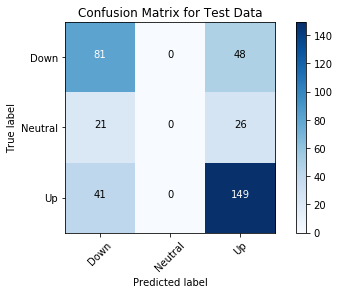

In [45]:
plot_confusion_matrix(cm)

In [46]:
#Precision & Recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(true, pred, average='micro')
recall = recall_score(true, pred, average='micro')

print("Precision: %.2f " % precision, "Recall: %.2f " % recall)


Precision: 0.63  Recall: 0.63 


## Zooming in whats happening to the mis-labeled ones

In [47]:
#Get dates of the validation set
_, _, dates_test = split_data(dates, train_size=0.7, val_size=0.15, test_size=0.15)
_, _, ret_test = split_data(ret, train_size=0.7, val_size=0.15, test_size=0.15)
dates_test = dates_test[:len(true)]
ret_test = ret_test[:len(true)]

In [48]:
y_test_best.shape

(366, 3)

In [49]:
dates_test[-10:]

array(['2017-09-27T00:00:00.000000000', '2017-09-28T00:00:00.000000000',
       '2017-09-29T00:00:00.000000000', '2017-10-03T00:00:00.000000000',
       '2017-10-04T00:00:00.000000000', '2017-10-06T00:00:00.000000000',
       '2017-10-09T00:00:00.000000000', '2017-10-10T00:00:00.000000000',
       '2017-10-11T00:00:00.000000000', '2017-10-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [50]:
y_test_best[:10, :]

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [53]:
len(ret_test)

366

In [52]:
true[:10]

array([2, 0, 0, 2, 0, 0, 0, 0, 0, 0])

In [54]:
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
ret_test[:10]

array([ 0.0207142 , -0.00685717, -0.01153415,  0.00693644, -0.00230681,
       -0.00695252, -0.01641303, -0.01909366, -0.00241255, -0.00727276])

In [56]:
#Get the mislabelled dates
mislabelled = pred_prob[true != pred]
mislabelled_dates = dates_test[true != pred]

In [57]:
missed_ret = pd.DataFrame(ret[mislabelled_dates])
missed_ret.columns = ['FR']
missed_prob = pd.DataFrame(mislabelled, index=mislabelled_dates)

In [58]:
features = pd.concat([price_hist_data, idx_data, fund_data], axis=1)
missed_features = features[features.index.isin(mislabelled_dates)]

In [59]:
missed = pd.concat([missed_prob, missed_ret, missed_features], axis=1)

In [60]:
missed

,0,1,2,FR,P,P_L1,P_L2,P_L3,P_L4,P_L5,...,DY_LTM,DY_NTM,ADV_VOL,PAYOUT,ANALYST_SENTIMENT,EPS_GRW_FY1,EPS_GRW_FY2,PE_NTM,PE_LTM,C2D_LTM
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-20,0.434756,0.146788,0.418456,0.020714,21.50,21.75,21.45,21.60,21.70,21.50,...,4.068474,3.828978,11.590799,42.461478,-1.963735,-1.073369,10.123532,11.103367,10.603759,67.595408
2016-04-25,0.515386,0.044461,0.440153,0.006936,21.55,21.80,21.95,21.50,21.75,21.45,...,4.057479,3.811668,16.482112,42.785891,-2.043126,-2.152342,10.778901,11.239259,10.675289,67.427745
2016-05-06,0.614321,0.086325,0.299354,0.004938,20.20,20.55,20.70,20.75,21.15,21.50,...,4.118244,4.038814,1.691289,42.584806,-1.604566,-0.976716,10.912583,10.558240,10.484934,67.499839
2016-05-09,0.524602,0.100390,0.375008,0.007362,20.30,20.20,20.55,20.70,20.75,21.15,...,4.110919,4.026861,28.483613,42.550607,-1.198167,-1.345243,10.840772,10.581369,10.501459,67.377066
2016-05-13,0.583513,0.043036,0.373451,0.008515,19.88,20.05,20.20,20.45,20.30,20.20,...,4.139031,4.116072,7.450106,42.710777,-1.511836,-0.992540,10.530333,10.390811,10.437566,67.484042
2016-05-16,0.621057,0.037761,0.341182,0.012392,20.05,19.88,20.05,20.20,20.45,20.30,...,4.124824,4.079034,30.256050,42.691693,-1.496387,-1.121846,10.446739,10.479852,10.478562,70.105337
2016-05-19,0.484771,0.040109,0.475120,0.013490,19.88,19.96,20.30,20.05,19.88,20.05,...,4.131142,4.099246,6.892680,42.630444,-1.144312,-1.416077,10.559742,10.412988,10.461944,70.146143
2016-05-20,0.294101,0.041132,0.664767,-0.007472,20.15,19.88,19.96,20.30,20.05,19.88,...,4.121650,4.075130,93.051118,42.661645,-1.082689,-1.405518,10.403447,10.481982,10.490051,70.116864
2016-05-31,0.269983,0.063072,0.666945,-0.004751,21.10,20.85,20.80,20.65,20.60,20.10,...,4.028097,3.863667,73.114029,42.515740,-1.101235,-2.046212,10.193240,11.017405,10.750139,70.098490


In [61]:
missed.to_csv('missed_analysis.csv')

In [62]:
pd.DataFrame(pred_prob, index=dates_test).to_csv('pred_prob.csv')